In [79]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


In [80]:
ROOT = Path('/home/kylehiroyasu/programming/masters_thesis/stochastic-YOLO')

In [81]:
files = [
    'ccpd_blur.csv',
    'ccpd_blur_dropout.csv',
    'ccpd_challenge.csv',
    'ccpd_challenge_dropout.csv',
    'ccpd_db.csv',
    'ccpd_db_dropout.csv',
    'ccpd_fn.csv',
    'ccpd_fn_dropout.csv',
    'ccpd_rotate.csv',
    'ccpd_rotate_dropout.csv',
    'ccpd_tilt.csv',
    'ccpd_tilt_dropout.csv'
]

In [82]:
def load_data(path: str):
    all_predictions = []
    with open(path, mode='r') as f:
        for line in f.readlines():
            prediction = json.loads(line)
            for correct, confidence in zip(prediction['correct'], prediction['confidence']):
                data = {
                    'image_name': prediction['image_name'],
                    'correct': correct[0],
                    'confidence': confidence
                }
                all_predictions.append(data)
    return pd.DataFrame(all_predictions)

In [96]:
def plot_calibration_curve(data_dict: dict, dataset_name: str,  fig_index):


    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for name, df in data_dict.items():
        y_test = df.correct
        prob_pos = df.confidence
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        #print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        #print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        #print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plots {dataset_name} (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [97]:
groups = ['blur', 'challenge', 'db', 'fn', 'rotate', 'tilt']

In [98]:
datasets = []
for i in range(0, len(files), 2):
    data = load_data(ROOT/files[i])
    dropout_data = load_data(ROOT/files[i+1])
    datasets.append({
        'w/o MC-Dropout': data,
        'w/ MC-Dropout (10 samples)': dropout_data
    })

w/o MC-Dropout:
	Brier: 0.246
w/ MC-Dropout:
	Brier: 0.264
w/o MC-Dropout:
	Brier: 0.244
w/ MC-Dropout:
	Brier: 0.271
w/o MC-Dropout:
	Brier: 0.234
w/ MC-Dropout:
	Brier: 0.259
w/o MC-Dropout:
	Brier: 0.195
w/ MC-Dropout:
	Brier: 0.198
w/o MC-Dropout:
	Brier: 0.281
w/ MC-Dropout:
	Brier: 0.315
w/o MC-Dropout:
	Brier: 0.243
w/ MC-Dropout:
	Brier: 0.265


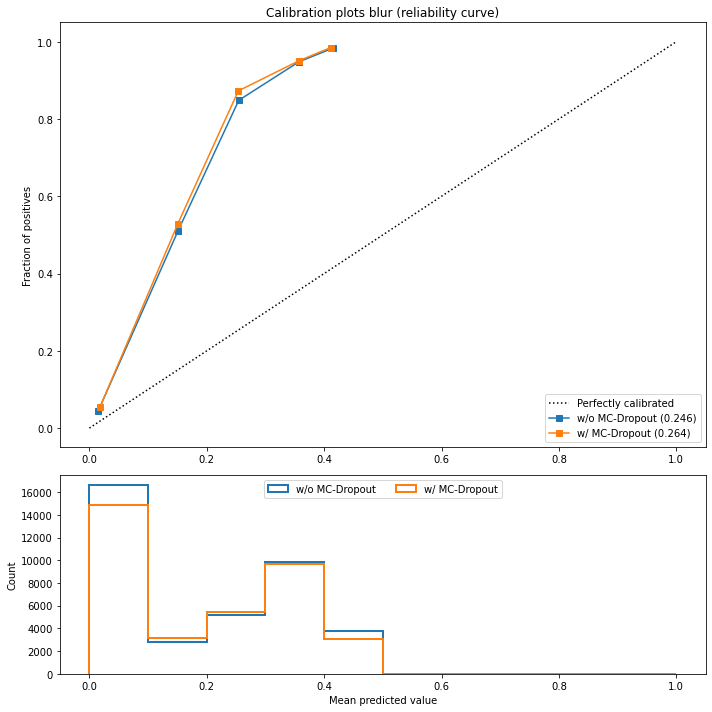

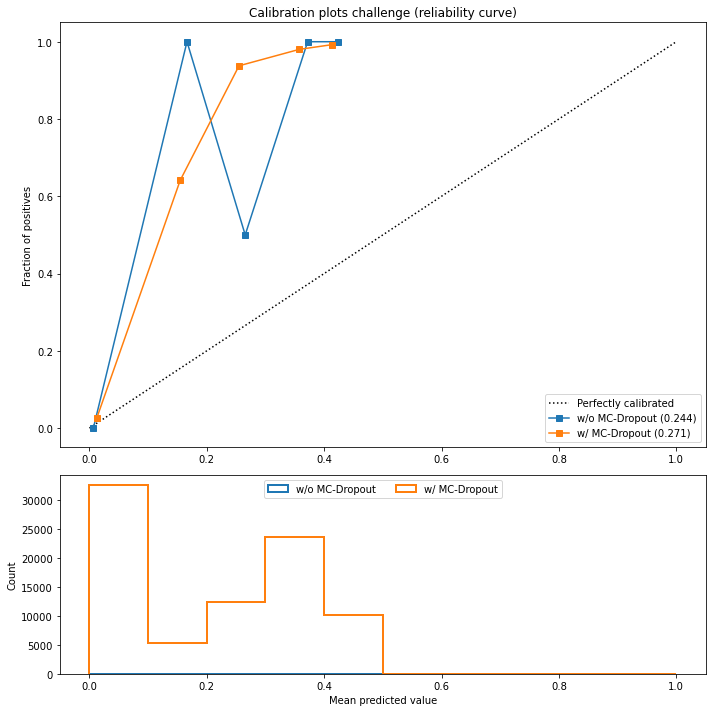

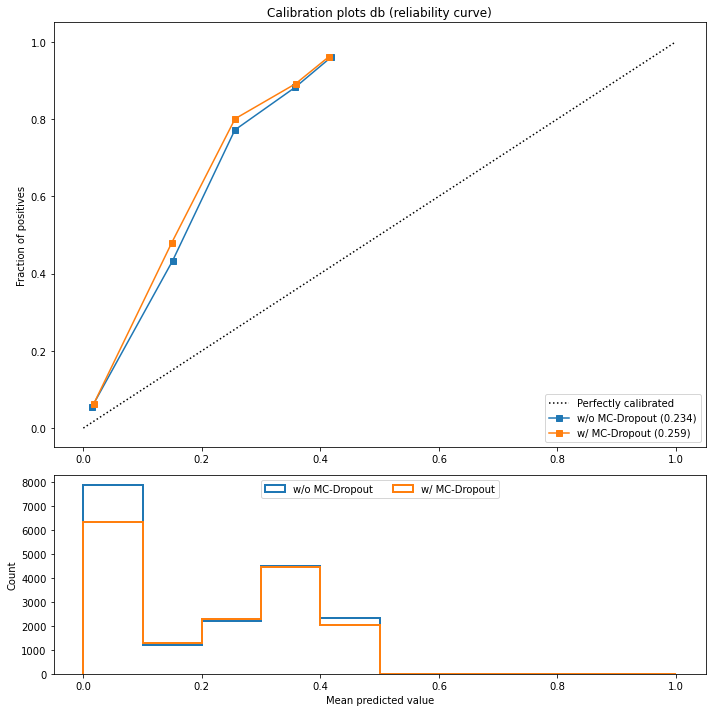

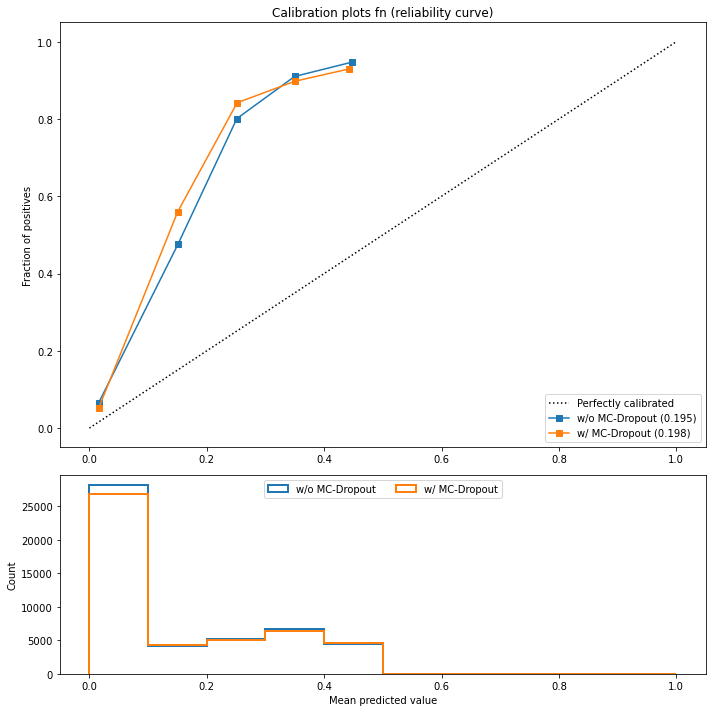

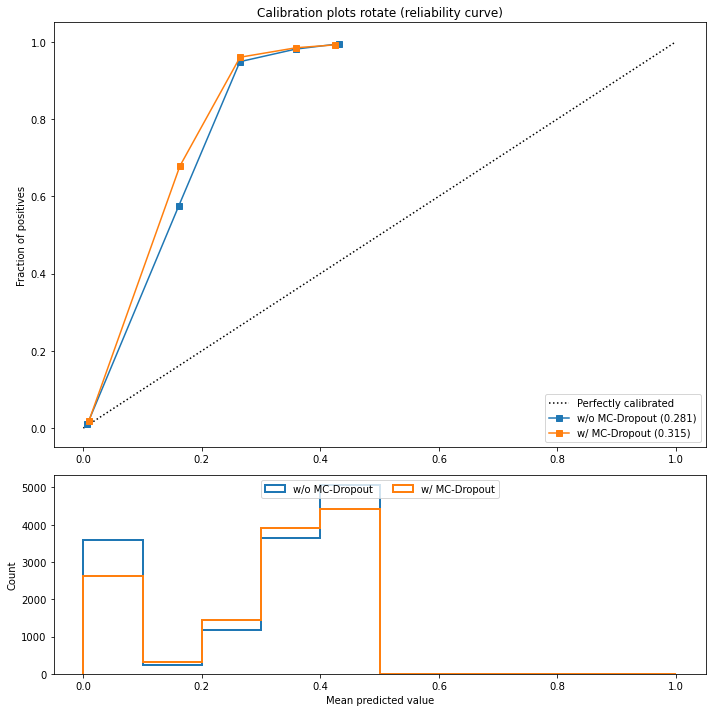

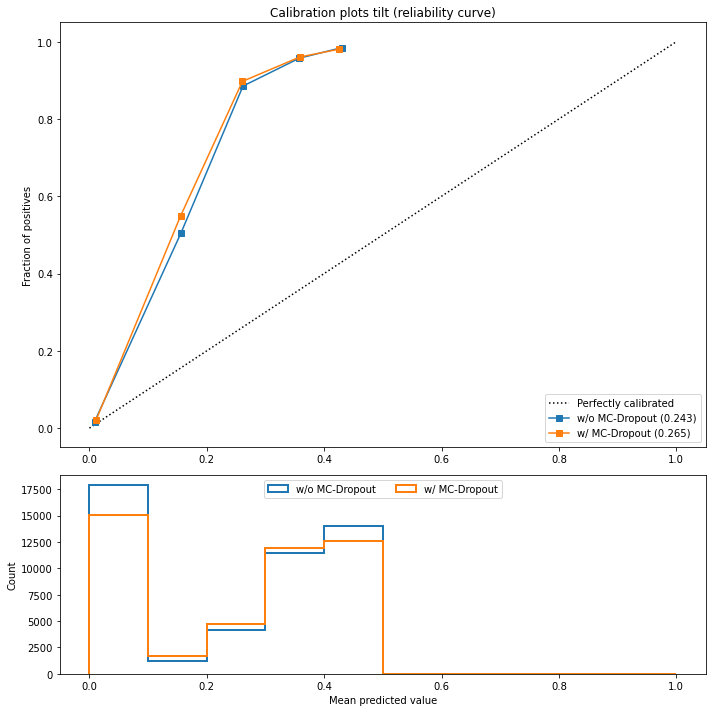

In [99]:
for i, (name, data_dict) in enumerate(zip(groups, datasets)):
    plot_calibration_curve(data_dict=data_dict, dataset_name=name, fig_index=i)